# Autotalker Benchmarking

- **Creator**: Sebastian Birk (<sebastian.birk@helmholtz-munich.de>).
- **Affiliation:** Helmholtz Munich, Institute of Computational Biology (ICB), Talavera-López Lab
- **Date of Creation:** 07.12.2022
- **Date of Last Modification:** 04.01.2023

## 1. Setup

### 1.1 Import Libraries

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append("..")

In [3]:
import itertools
import os
import random
import warnings
from datetime import datetime

import anndata as ad
import matplotlib
import matplotlib.pyplot as plt
import mlflow
import numpy as np
import pandas as pd
import scanpy as sc
import scipy.sparse as sp
import seaborn as sns
import squidpy as sq

from autotalker.models import Autotalker
from autotalker.utils import (add_gps_from_gp_dict_to_adata,
                              extract_gp_dict_from_mebocost_es_interactions,
                              extract_gp_dict_from_nichenet_ligand_target_mx,
                              extract_gp_dict_from_omnipath_lr_interactions,
                              filter_and_combine_gp_dict_gps)

### 1.2 Define Parameters

In [4]:
## Model
# Dataset
dataset = "squidpy_seqfish_mouse_organogenesis"

# Anndata Keys
counts_key = "counts"
cell_type_key = "celltype_mapped_refined"
adj_key = "spatial_connectivities"
spatial_key = "spatial"
gp_names_key = "autotalker_gp_names"
active_gp_names_key = "autotalker_active_gp_names"
gp_targets_mask_key = "autotalker_gp_targets"
gp_sources_mask_key = "autotalker_gp_sources"
latent_key = "autotalker_latent"

## Others
random_seed = 42

### 1.3 Run Notebook Setup

In [5]:
# Ignore future warnings and user warnings
warnings.simplefilter(action="ignore", category=FutureWarning)
warnings.simplefilter(action="ignore", category=UserWarning)

### 1.4 Configure Paths and Create Directories

In [6]:
# Define paths
figure_path = "../figures"
model_artifacts_path = "../model_artifacts"
gp_data_folder_path = "../datasets/gp_data" # gene program data
srt_data_folder_path = "../datasets/srt_data" # spatially resolved transcriptomics data
srt_data_gold_folder_path = f"{srt_data_folder_path}/gold"
nichenet_ligand_target_mx_file_path = gp_data_folder_path + "/nichenet_ligand_target_matrix.csv"
omnipath_lr_interactions_file_path = gp_data_folder_path + "/omnipath_lr_interactions.csv"

# Create required directories
os.makedirs(figure_path, exist_ok=True)
os.makedirs(model_artifacts_path, exist_ok=True)
os.makedirs(gp_data_folder_path, exist_ok=True)

### 1.5 Define Functions

In [7]:
def run_hyperparam_benchmarking(dataset,
                                hyperparam_option_dict,
                                n_iters,
                                experiment_name,
                                gp_mask="combined_priors",
                                save_figures=False,
                                save_model=False):
    # Read dataset
    print("--- DATASET ---")
    print(f"Using dataset {dataset}.")
    adata = ad.read_h5ad(f"{srt_data_gold_folder_path}/{dataset}.h5ad")
    n_nodes = adata.layers["counts"].shape[0]
    n_genes = adata.layers["counts"].shape[1]
    print(f"Number of nodes (cells): {n_nodes}.")
    print(f"Number of node features (genes): {n_genes}.")
        
    # Retrieve gene program mask
    print("")
    print("--- GENE PROGRAMS ---")
    print(f"Using '{gp_mask}' GP mask.")
    
    if gp_mask == "fc":
        n_output = len(adata.var) * 2
        adata.varm[gp_targets_mask_key] = np.ones((int(len(adata.var) / 2), len(adata.var)))
        adata.varm[gp_sources_mask_key] = np.ones((int(len(adata.var) / 2), len(adata.var)))
        adata.uns[gp_names_key] = np.array([f"FC_GP_{i}" for i in range(int(len(adata.var) / 2))])
    
    elif gp_mask == "combined_priors":
        nichenet_keep_target_ratio = 0.01
        omnipath_min_curation_effort = 0
        gp_filter_mode = "subset"
        combine_overlap_gps = True
        overlap_thresh_source_genes = 0.9
        overlap_thresh_target_genes = 0.9
        overlap_thresh_genes = 0.9
        min_genes_per_gp = 1
        min_source_genes_per_gp = 0
        min_target_genes_per_gp = 0
        
        nichenet_gp_dict = extract_gp_dict_from_nichenet_ligand_target_mx(
            keep_target_ratio=nichenet_keep_target_ratio,
            load_from_disk=False,
            save_to_disk=True,
            file_path=nichenet_ligand_target_mx_file_path)
        omnipath_gp_dict = extract_gp_dict_from_omnipath_lr_interactions(
            min_curation_effort=omnipath_min_curation_effort,
            load_from_disk=False,
            save_to_disk=True,
            file_path=omnipath_lr_interactions_file_path)
        mebocost_gp_dict = extract_gp_dict_from_mebocost_es_interactions(
            dir_path = "../datasets/gp_data/metabolite_enzyme_sensor_gps/",
            species="mouse",
            genes_uppercase=True)
        combined_gp_dict = dict(nichenet_gp_dict)
        combined_gp_dict.update(omnipath_gp_dict)
        combined_gp_dict.update(mebocost_gp_dict)

        # Filter and combine gene programs
        combined_new_gp_dict = filter_and_combine_gp_dict_gps(
            gp_dict=combined_gp_dict,
            gp_filter_mode=gp_filter_mode,
            combine_overlap_gps=combine_overlap_gps,
            overlap_thresh_source_genes=overlap_thresh_source_genes,
            overlap_thresh_target_genes=overlap_thresh_target_genes,
            overlap_thresh_genes=overlap_thresh_genes,
            verbose=True)

        print(f"Number of gene programs before filtering and combining: {len(combined_gp_dict)}.")
        print(f"Number of gene programs after filtering and combining: {len(combined_new_gp_dict)}.")
        
        # Add the gene program dictionary as binary masks to the adata for model training
        add_gps_from_gp_dict_to_adata(
            gp_dict=combined_new_gp_dict,
            adata=adata,
            genes_uppercase=True,
            gp_targets_mask_key=gp_targets_mask_key,
            gp_sources_mask_key=gp_sources_mask_key,
            gp_names_key=gp_names_key,
            min_genes_per_gp=min_genes_per_gp,
            min_source_genes_per_gp=min_source_genes_per_gp,
            min_target_genes_per_gp=min_target_genes_per_gp,
            max_genes_per_gp=None,
            max_source_genes_per_gp=None,
            max_target_genes_per_gp=None)
        
    # Summarize gene programs
    print(f"Number of gene programs with probed genes: {len(adata.uns['autotalker_gp_names'])}.")
    print(f"Example gene programs: {random.sample(list(adata.uns['autotalker_gp_names']), 5)}.")
    print(f"Number of gene program target genes: {adata.varm['autotalker_gp_targets'].sum()}.")
    print(f"Number of gene program source genes: {adata.varm['autotalker_gp_sources'].sum()}.")

    # Loop `n_iters` times through combination of hyperparams 
    iters = range(n_iters)
    hyperparams, hyperparam_values = zip(*hyperparam_option_dict.items())
    for hyperparam_comb in itertools.product(*hyperparam_values, iters):
        hyperparam_dict = {}
        for hyperparam, hyperparam_value in zip(hyperparams, hyperparam_comb):
            hyperparam_dict[hyperparam] = hyperparam_value
        
        experiment = mlflow.set_experiment(experiment_name)
            
        # Log dataset params
        mlflow.log_param("dataset", dataset)
        mlflow.log_param("n_nodes", n_nodes)
        mlflow.log_param("n_genes", n_genes)
    
        # Log gp mask params
        mlflow.log_param("gp_mask", gp_mask)
        mlflow.log_param("nichenet_keep_target_ratio", nichenet_keep_target_ratio)
        mlflow.log_param("omnipath_min_curation_effort", omnipath_min_curation_effort)
        mlflow.log_param("gp_filter_mode", gp_filter_mode)
        mlflow.log_param("combine_overlap_gps", combine_overlap_gps)
        mlflow.log_param("overlap_thresh_source_genes", overlap_thresh_source_genes)
        mlflow.log_param("overlap_thresh_target_genes", overlap_thresh_target_genes)
        mlflow.log_param("overlap_thresh_genes", overlap_thresh_genes)
        mlflow.log_param("min_genes_per_gp", min_genes_per_gp)
        mlflow.log_param("min_source_genes_per_gp", min_source_genes_per_gp)
        mlflow.log_param("min_target_genes_per_gp", min_target_genes_per_gp) 
        
        if save_figures:
            # Get time for timestamping saved artifacts
            now = datetime.now()
            current_timestamp = now.strftime("%d%m%Y_%H%M%S")

            benchmark_fig_run_dir = f"{figure_path}/{dataset}/benchmarking/{experiment_name}/runs/{current_timestamp}"
            os.makedirs(benchmark_fig_run_dir, exist_ok=True)
            benchmark_model_run_dir = f"{model_artifacts_path}/{dataset}/benchmarking/{experiment_name}/runs/{current_timestamp}"
            os.makedirs(benchmark_model_run_dir, exist_ok=True)
        
        # Copy adata
        adata_run = adata.copy()

        print("")
        print("--- SPATIAL CONNECTIVITY ---")
        # Compute spatial neighborhood
        sq.gr.spatial_neighbors(adata_run,
                                coord_type="generic",
                                spatial_key=spatial_key,
                                radius=hyperparam_dict["radius"])
        # ax = sns.histplot(np.squeeze(np.asarray(adata_run.obsp['spatial_connectivities'].sum(axis=0))),
        #                   discrete=True)
        # ax.set_title("Node Counts Per Number of Neighbors")
        # ax.set_ylabel("Node Count")
        # ax.set_xlabel("Number of Neighbors")
        # fig = ax.figure
        # fig.savefig(f"{benchmark_fig_run_dir}/node_counts_per_n_neighs.png",
        #             bbox_inches="tight")
        # plt.close(fig)
        avg_edges_per_node = round(adata_run.obsp['spatial_connectivities'].sum(axis=0).mean(), 2)
        print(f"Average number of edges per node: {avg_edges_per_node}.")
        n_edges = int(sp.triu(adata_run.obsp['spatial_connectivities'], k=1).sum())
        print(f"Number of total edges: {n_edges}.")
        mlflow.log_param("avg_n_neighbors", avg_edges_per_node)
        mlflow.log_param("n_edges", n_edges)
        avg_n_neighbors_rounded = int(round(avg_edges_per_node))

        # Initialize model
        print("")
        if hyperparam_dict["n_hidden_encoder_divisor"] is None:
            n_hidden_encoder = len(adata.uns[gp_names_key]) # gp mask size
        else:
            n_hidden_encoder = int(len(adata.var) / hyperparam_dict["n_hidden_encoder_divisor"])
        model = Autotalker(adata_run,
                           counts_key=counts_key,
                           adj_key=adj_key,
                           gp_names_key=gp_names_key,
                           active_gp_names_key=active_gp_names_key,
                           gp_targets_mask_key=gp_targets_mask_key,
                           gp_sources_mask_key=gp_sources_mask_key,
                           latent_key=latent_key,
                           gene_expr_recon_dist=hyperparam_dict["gene_expr_recon_dist"],
                           node_label_method=hyperparam_dict["node_label_method"],
                           active_gp_thresh_ratio=hyperparam_dict["active_gp_thresh_ratio"],
                           n_hidden_encoder=n_hidden_encoder,
                           conv_layer_encoder=hyperparam_dict["conv_layer_encoder"],
                           encoder_n_attention_heads=hyperparam_dict["encoder_n_attention_heads"])

        # Train model
        print("")
        model.train(n_epochs=hyperparam_dict["n_epochs"],
                    n_epochs_all_gps=hyperparam_dict["n_epochs_all_gps"],
                    lr=hyperparam_dict["lr"],
                    lambda_edge_recon=hyperparam_dict["lambda_edge_recon"],
                    lambda_gene_expr_recon=hyperparam_dict["lambda_gene_expr_recon"],
                    lambda_group_lasso=hyperparam_dict["lambda_group_lasso"],
                    edge_batch_size=hyperparam_dict["batch_size"],
                    node_batch_size=hyperparam_dict["batch_size"],
                    mlflow_experiment_id=experiment.experiment_id,
                    verbose=True)
        
        if save_figures:
            # Log visualizations
            # Use autotalker latent space for UMAP generation
            sc.pp.neighbors(model.adata, use_rep=latent_key)
            sc.tl.umap(model.adata, min_dist=0.3)

            # Create subplot of cell-type annotations in spatial and latent space
            fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(10, 29))
            title = fig.suptitle(t="Cell-type Annotations in Spatial and Latent Space",
                                 x=0.85,
                                 y=0.925,
                                 fontsize=20)
            sc.pl.spatial(adata=model.adata,
                          color=[cell_type_key],
                          spot_size=0.03,
                          title="Spatial Space",
                          ax=axs[0],
                          show=False)
            sc.pl.umap(adata=model.adata,
                       color=[cell_type_key],
                       title="Latent Space",
                       ax=axs[1],
                       show=False)
            handles, labels = axs[0].get_legend_handles_labels()
            lgd = fig.legend(handles, labels, bbox_to_anchor=(1.225, 0.625))
            axs[0].get_legend().remove()
            axs[1].get_legend().remove()
            plt.subplots_adjust(wspace=0, hspace=0.1)
            fig.savefig(f"{benchmark_fig_run_dir}/cell_type_annotations_in_spatial_and_latent_space.png",
                        bbox_extra_artists=(lgd, title),
                        bbox_inches="tight")
            plt.close(fig)

            # Create subplot of latent Leiden cluster annotations in latent and spatial space
            resolution = 0.3
            model.compute_latent_graph_connectivities(adata=model.adata,
                                                      n_neighbors=int(round(avg_edges_per_node)),
                                                      mode="knn",
                                                      seed=random_seed)
            sc.tl.leiden(adata=model.adata,
                         resolution=resolution,
                         random_state=random_seed,
                         key_added=f"leiden_latent_{str(resolution)}",
                         adjacency=model.adata.obsp["latent_connectivities"])
            fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(10, 20))
            title = fig.suptitle(t="Latent Leiden Cluster Annotations in Latent and Spatial Space",
                                 x=0.85,
                                 y=0.925,
                                 fontsize=20)
            sc.pl.umap(adata=model.adata,
                       color=[f"leiden_latent_{str(resolution)}"],
                       title=f"Latent Space",
                       ax=axs[0],
                       show=False)
            sc.pl.spatial(adata=model.adata,
                          color=[f"leiden_latent_{str(resolution)}"],
                          spot_size=0.03,
                          title=f"Spatial Space",
                          ax=axs[1],
                          show=False)
            handles, labels = axs[0].get_legend_handles_labels()
            lgd = fig.legend(handles, labels, bbox_to_anchor=(1.025, 0.7))
            axs[0].get_legend().remove()
            axs[1].get_legend().remove()
            plt.subplots_adjust(wspace=0, hspace=0.1)
            fig.savefig(f"{benchmark_fig_run_dir}/latent_leiden_cluster_annotations_in_latent_and_spatial_space.png",
                        bbox_extra_artists=(lgd, title),
                        bbox_inches="tight")
            plt.close(fig)

            mlflow.log_artifacts(benchmark_fig_run_dir,
                                 current_timestamp)
        
        if save_model:            
            model.save(dir_path=benchmark_model_run_dir,
                       overwrite=True,
                       save_adata=True,
                       adata_file_name=f"{dataset}.h5ad")

        mlflow.end_run()
        print("--------------------")
        print("")
        print("--------------------")

In [19]:
def plot_hyperparam_benchmarking_metrics(fig_title,
                                         df,
                                         y_col_name,
                                         sort_col="val_mse_score",
                                         plot_ratio_active_gps=False,
                                         save_fig=False,
                                         file_name="benchmarking_metrics.png"):
    # Compute evaluation metric ranks for sorting
    val_mse_score_ranks = (df.groupby([y_col_name])
                           ["val_mse_score"].mean().rank(ascending=True)
                           .rename("val_mse_score_rank"))
    val_auroc_score_ranks = (df.groupby([y_col_name])
                                ["val_auroc_score"].mean().rank(ascending=False)
                                .rename("val_auroc_score_rank"))
    df = df.merge(val_mse_score_ranks, on=[y_col_name])
    df = df.merge(val_auroc_score_ranks, on=[y_col_name])

    if sort_col == "val_mse_score":
        df.sort_values(by=["val_mse_score_rank", y_col_name],
                       inplace=True,
                       ascending=False)
    elif sort_col == "val_auroc_score":
        df.sort_values(by=["val_auroc_score_rank", y_col_name],
                       inplace=True,
                       ascending=False)
    elif sort_col == "total_score":
        df["val_total_score_rank"] = (df["val_mse_score_rank"] + 
                                      df["val_auroc_score_rank"]).rank(ascending=True)
        df.sort_values(by=["val_total_score_rank", y_col_name],
                       inplace=True,
                       ascending=False)
    
    if plot_ratio_active_gps:
        fig, axes = plt.subplots(3, 1, sharey=True, figsize=(10, 20))
        sns.boxplot(data=df, ax=axes[2], x="ratio_active_gps", y=y_col_name)
        axes[2].set_title("Ratio of Active Gene Programs")
    else:
        fig, axes = plt.subplots(2, 1, sharey=True, figsize=(10, 15))
    fig.suptitle(fig_title, fontsize=15)
    sns.boxplot(data=df, ax=axes[0], x="val_auroc_score", y=y_col_name)
    axes[0].set_title("Edge Reconstruction Area Under ROC Curve")
    sns.boxplot(data=df, ax=axes[1], x="val_mse_score", y=y_col_name)
    axes[1].set_title("Gene Expression Reconstruction Mean Squared Error")
    plt.subplots_adjust(left=0.1,
                        bottom=0.1,
                        right=0.9,
                        top=0.94,
                        wspace=0.175,
                        hspace=0.175)
    if save_fig:
        # Get time for timestamping saved artefacts
        now = datetime.now()
        current_timestamp = now.strftime("%d%m%Y_%H%M%S")
        benchmark_fig_run_dir = f"{figure_path}/{dataset}/benchmarking/{experiment_name}/results/{current_timestamp}"
        os.makedirs(benchmark_fig_run_dir, exist_ok=True)
        plt.savefig(f"{benchmark_fig_run_dir}/{file_name}",
                    bbox_inches='tight')

## 2. Hyperparameter Benchmarking Experiments

### 2.1. Benchmark Loss Weights

- Different combinations of the edge reconstruction loss and gene expression reconstruction loss weighting hyperparameters are tested.
- Average number of neighbors is varied. The radius is set in order to get an average number of neighbors of ```2```, ```4```, ```8```, ```16``` and ```32``` with 2 iterations respectively, resulting in a total of 10 runs per loss weight combination.

In [10]:
experiment_name = "benchmark_loss_weights"

# Set hyperparameters that are not varied as part of the experiment
hyperparam_option_dict = {}
hyperparam_option_dict["node_label_method"] = ["one-hop-attention"]
hyperparam_option_dict["gene_expr_recon_dist"] = ["nb"]
hyperparam_option_dict["conv_layer_encoder"] = ["gcnconv"]
hyperparam_option_dict["encoder_n_attention_heads"] = [0]
hyperparam_option_dict["n_hidden_encoder_divisor"] = [None]
hyperparam_option_dict["active_gp_thresh_ratio"] = [0.]
hyperparam_option_dict["lambda_group_lasso"] = [0]

hyperparam_option_dict["n_epochs"] = [20]
hyperparam_option_dict["n_epochs_all_gps"] = [10]
hyperparam_option_dict["lr"] = [0.001]
hyperparam_option_dict["batch_size"] = 64

In [ ]:
hyperparam_option_dict["radius"] = [0.03094, 0.03875, 0.05102, 0.07200, 0.10241]
hyperparam_option_dict["lambda_edge_recon"] = [0, 0.1, 0.2, 0.33, 0.5, 1.]
hyperparam_option_dict["lambda_gene_expr_recon"] = [1.]

model = run_hyperparam_benchmarking(dataset=dataset,
                                    hyperparam_option_dict=hyperparam_option_dict,
                                    n_iters=2,
                                    experiment_name=experiment_name,
                                    gp_mask="combined_priors",
                                    save_model=False)

--- DATASET ---
Using dataset squidpy_seqfish_mouse_organogenesis.
Number of nodes (cells): 19416.
Number of node features (genes): 351.

--- GENE PROGRAMS ---
Using 'combined_priors' GP mask.
Removing GP 'CTF1_ligand_receptor_GP' as it is a subset of GP 'CTF1_ligand_targetgenes_GP'.
Removing GP 'LEP_ligand_receptor_GP' as it is a subset of GP 'LEP_ligand_targetgenes_GP'.
Removing GP 'IL4_ligand_receptor_GP' as it is a subset of GP 'IL4_ligand_targetgenes_GP'.
Removing GP 'IL12A_ligand_receptor_GP' as it is a subset of GP 'IL12A_ligand_targetgenes_GP'.
Removing GP 'IL23A_ligand_receptor_GP' as it is a subset of GP 'IL23A_ligand_targetgenes_GP'.
Removing GP 'CSF2_ligand_receptor_GP' as it is a subset of GP 'CSF2_ligand_targetgenes_GP'.
Removing GP 'IL21_ligand_receptor_GP' as it is a subset of GP 'IL21_ligand_targetgenes_GP'.
Removing GP 'TSLP_ligand_receptor_GP' as it is a subset of GP 'TSLP_ligand_targetgenes_GP'.
Removing GP 'GH2_ligand_receptor_GP' as it is a subset of GP 'GH2_ligan

In [ ]:
hyperparam_option_dict["radius"] = [0.10241] # [0.03094, 0.03875, 0.05102, 0.07200, 0.10241]
hyperparam_option_dict["lambda_edge_recon"] = [1.]
hyperparam_option_dict["lambda_gene_expr_recon"] = [0, 0.1, 0.2, 0.33, 0.5]

model = run_hyperparam_benchmarking(dataset=dataset,
                                    hyperparam_option_dict=hyperparam_option_dict,
                                    n_iters=2,
                                    experiment_name=experiment_name,
                                    gp_mask="combined_priors",
                                    save_model=False)

In [15]:
runs = mlflow.search_runs(experiment_names=[experiment_name],
                          output_format="list")

data = []
for run in runs:
    data.append({**run.data.metrics, **run.data.params})
df = pd.DataFrame.from_dict(data)

def get_loss_weights(row):  
    return f"lambda_edge_recon_{row['lambda_edge_recon_']}_+_lambda_gene_expr_recon_{row['lambda_gene_expr_recon_']}"
df["loss_weights"] = df.apply(lambda row: get_loss_weights(row), axis=1)

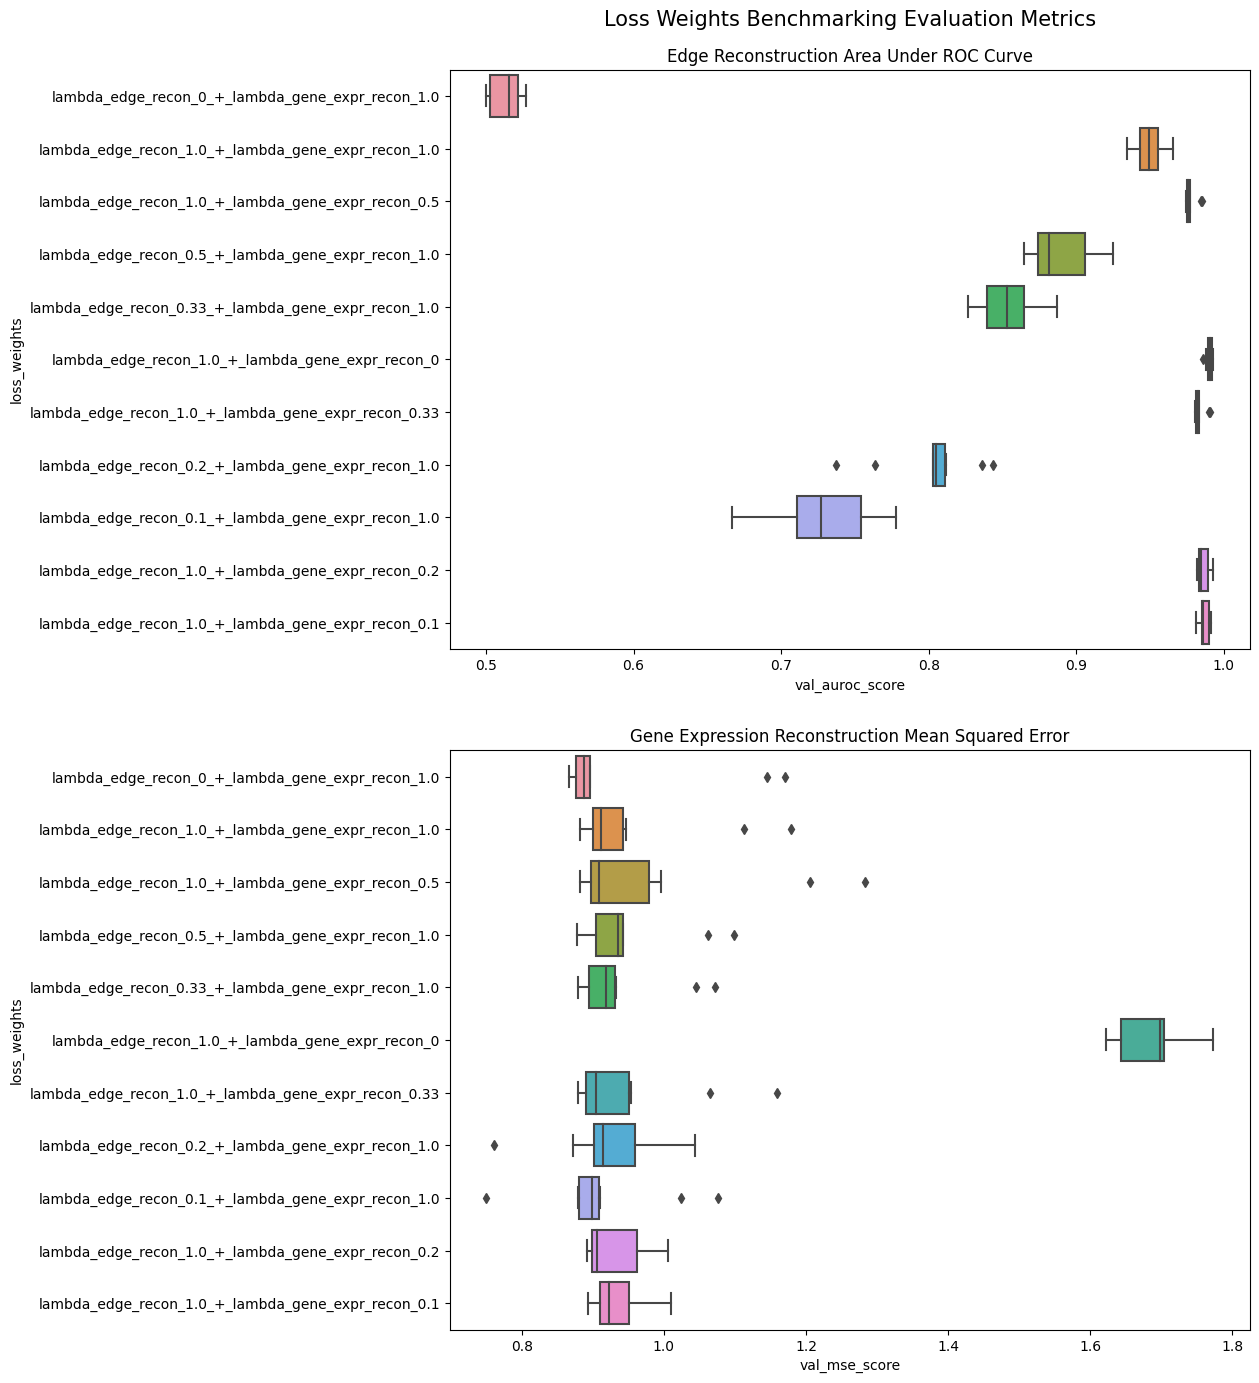

In [20]:
plot_eval_metrics(fig_title="Loss Weights Benchmarking Evaluation Metrics",
                  df=df,
                  y_col_name="loss_weights",
                  plot_ratio_active_gps=False,
                  file_name="loss_weights_benchmarking_eval_metrics.png",
                  save_fig=True)

### 2.2. Benchmark Node Label Method

- Different node label methods are tested.
- Average number of neighbors is varied. The radius is set in order to get an average number of neighbors of ```2```, ```4```, ```8```, ```16``` and ```32``` with 2 iterations respectively, resulting in a total of 10 runs per node label method.

In [ ]:
experiment_name = "benchmark_node_label_method"

# Set hyperparameters that are not varied as part of the experiment
hyperparam_option_dict = {}
hyperparam_option_dict["lambda_edge_recon"] = [1.]
hyperparam_option_dict["lambda_gene_expr_recon"] = [0.33]
hyperparam_option_dict["gene_expr_recon_dist"] = ["nb"]
hyperparam_option_dict["conv_layer_encoder"] = ["gcnconv"]
hyperparam_option_dict["encoder_n_attention_heads"] = [0]
hyperparam_option_dict["n_hidden_encoder_divisor"] = [None]
hyperparam_option_dict["active_gp_thresh_ratio"] = [0.]
hyperparam_option_dict["lambda_group_lasso"] = [0]

hyperparam_option_dict["n_epochs"] = [20]
hyperparam_option_dict["n_epochs_all_gps"] = [10]
hyperparam_option_dict["lr"] = [0.001]
hyperparam_option_dict["batch_size"] = 64

In [ ]:
hyperparam_option_dict["radius"] = [0.03094, 0.03875, 0.05102, 0.07200, 0.10241]
hyperparam_option_dict["node_label_method"] = ["one-hop-attention", "one-hop-norm", "one-hop-sum"]

model = run_hyperparam_benchmarking(dataset=dataset,
                                    hyperparam_option_dict=hyperparam_option_dict,
                                    n_iters=2,
                                    experiment_name=experiment_name,
                                    gp_mask="combined_priors",
                                    save_model=False)

In [ ]:
runs = mlflow.search_runs(experiment_names=[experiment_name],
                          output_format="list")

data = []
for run in runs:
    data.append({**run.data.metrics, **run.data.params})
df = pd.DataFrame.from_dict(data)

In [ ]:
plot_eval_metrics(fig_title="Node Label Method Benchmarking Evaluation Metrics",
                  df=df,
                  y_col_name="node_label_method_",
                  plot_ratio_active_gps=False,
                  file_name="node_label_method_benchmarking_eval_metrics.png",
                  save_fig=True)

### 2.3. Benchmark Gene Expression Reconstruction Distribution

- Different gene expression reconstruction distributions are tested.
- Average number of neighbors is varied. The radius is set in order to get an average number of neighbors of ```2```, ```4```, ```8```, ```16``` and ```32``` with 2 iterations respectively, resulting in a total of 10 runs per gene expression reconstruction distribution.

In [ ]:
experiment_name = "benchmark_gene_expr_recon_dist"

# Set hyperparameters that are not varied as part of the experiment
hyperparam_option_dict = {}
hyperparam_option_dict["lambda_edge_recon"] = [1.]
hyperparam_option_dict["lambda_gene_expr_recon"] = [0.33]
hyperparam_option_dict["node_label_method"] = ["one-hop-attention"]
hyperparam_option_dict["conv_layer_encoder"] = ["gcnconv"]
hyperparam_option_dict["encoder_n_attention_heads"] = [0]
hyperparam_option_dict["n_hidden_encoder_divisor"] = [None]
hyperparam_option_dict["active_gp_thresh_ratio"] = [0.]
hyperparam_option_dict["lambda_group_lasso"] = [0]

hyperparam_option_dict["n_epochs"] = [20]
hyperparam_option_dict["n_epochs_all_gps"] = [10]
hyperparam_option_dict["lr"] = [0.001]
hyperparam_option_dict["batch_size"] = 64

In [ ]:
hyperparam_option_dict["radius"] = [0.03094, 0.03875, 0.05102, 0.07200, 0.10241]
hyperparam_option_dict["gene_expr_recon_dist"] = ["nb", "zinb"]

model = run_hyperparam_benchmarking(dataset=dataset,
                                    hyperparam_option_dict=hyperparam_option_dict,
                                    n_iters=2,
                                    experiment_name=experiment_name,
                                    gp_mask="combined_priors",
                                    save_model=False)

In [ ]:
runs = mlflow.search_runs(experiment_names=[experiment_name],
                          output_format="list")

data = []
for run in runs:
    data.append({**run.data.metrics, **run.data.params})
df = pd.DataFrame.from_dict(data)

In [ ]:
plot_eval_metrics(fig_title="Gene Expression Reconstruction Distribution Benchmarking Evaluation Metrics",
                  df=df,
                  y_col_name="gene_expr_recon_dist_",
                  plot_ratio_active_gps=False,
                  file_name="gene_expr_recon_dist_benchmarking_eval_metrics.png",
                  save_fig=True)

### 2.4. Benchmark Encoder Layer Architecture

- Different encoder layer architectures are tested.
- Average number of neighbors is varied. The radius is set in order to get an average number of neighbors of ```2```, ```4```, ```8```, ```16``` and ```32``` with 2 iterations respectively, resulting in a total of 10 runs per encoder layer architecture.

In [ ]:
experiment_name = "benchmark_encoder_layer_arch"

# Set hyperparameters that are not varied as part of the experiment
hyperparam_option_dict = {}
hyperparam_option_dict["lambda_edge_recon"] = [1.]
hyperparam_option_dict["lambda_gene_expr_recon"] = [0.33]
hyperparam_option_dict["node_label_method"] = ["one-hop-attention"]
hyperparam_option_dict["gene_expr_recon_dist"] = ["nb", "zinb"]
hyperparam_option_dict["n_hidden_encoder_divisor"] = [None]
hyperparam_option_dict["active_gp_thresh_ratio"] = [0.]
hyperparam_option_dict["lambda_group_lasso"] = [0]

hyperparam_option_dict["n_epochs"] = [20]
hyperparam_option_dict["n_epochs_all_gps"] = [10]
hyperparam_option_dict["lr"] = [0.001]
hyperparam_option_dict["batch_size"] = 64

In [ ]:
hyperparam_option_dict["radius"] = [0.03094, 0.03875, 0.05102, 0.07200, 0.10241]
hyperparam_option_dict["conv_layer_encoder"] = ["gcnconv"]
hyperparam_option_dict["encoder_n_attention_heads"] = [0]

model = run_hyperparam_benchmarking(dataset=dataset,
                                    hyperparam_option_dict=hyperparam_option_dict,
                                    n_iters=2,
                                    experiment_name=experiment_name,
                                    gp_mask="combined_priors",
                                    save_model=False)

In [ ]:
hyperparam_option_dict["radius"] = [0.03094, 0.03875, 0.05102, 0.07200, 0.10241]
hyperparam_option_dict["conv_layer_encoder"] = ["gatv2conv"]
hyperparam_option_dict["encoder_n_attention_heads"] = [1, 2, 4, 8]

model = run_hyperparam_benchmarking(dataset=dataset,
                                    hyperparam_option_dict=hyperparam_option_dict,
                                    n_iters=2,
                                    experiment_name=experiment_name,
                                    gp_mask="combined_priors",
                                    save_model=False)

In [ ]:
runs = mlflow.search_runs(experiment_names=[experiment_name],
                          output_format="list")

data = []
for run in runs:
    data.append({**run.data.metrics, **run.data.params})
df = pd.DataFrame.from_dict(data)

def get_encoder_layer_arch(row):  
    return f"conv_layer_encoder_{row['conv_layer_encoder_']}_+_encoder_n_attention_heads_{row['encoder_n_attention_heads_']}"
df["encoder_layer_arch"] = df.apply(lambda row: get_layer_encoder(row), axis=1)

In [ ]:
plot_eval_metrics(fig_title="Encoder Layer Architecture Benchmarking Evaluation Metrics",
                  df=df,
                  y_col_name="encoder_layer_arch",
                  plot_ratio_active_gps=False,
                  file_name="encoder_layer_arch_benchmarking_eval_metrics.png",
                  save_fig=True)

### 2.5. Benchmark Encoder Hidden Layer Size

- Different sizes of the encoder hidden layer are tested.
- Average number of neighbors is varied. The radius is set in order to get an average number of neighbors of ```2```, ```4```, ```8```, ```16``` and ```32``` with 2 iterations respectively, resulting in a total of 10 runs per encoder hidden layer size.

In [ ]:
experiment_name = "benchmark_encoder_n_hidden"

# Set hyperparameters that are not varied as part of the experiment
hyperparam_option_dict = {}
hyperparam_option_dict["lambda_edge_recon"] = [1.]
hyperparam_option_dict["lambda_gene_expr_recon"] = [0.33]
hyperparam_option_dict["node_label_method"] = ["one-hop-attention"]
hyperparam_option_dict["gene_expr_recon_dist"] = ["nb", "zinb"]
hyperparam_option_dict["conv_layer_encoder"] = ["gcnconv"]
hyperparam_option_dict["encoder_n_attention_heads"] = [0]
hyperparam_option_dict["active_gp_thresh_ratio"] = [0.]
hyperparam_option_dict["lambda_group_lasso"] = [0]

hyperparam_option_dict["n_epochs"] = [20]
hyperparam_option_dict["n_epochs_all_gps"] = [10]
hyperparam_option_dict["lr"] = [0.001]
hyperparam_option_dict["batch_size"] = 64

In [ ]:
hyperparam_option_dict["radius"] = [0.03094, 0.03875, 0.05102, 0.07200, 0.10241]
hyperparam_option_dict["n_hidden_encoder_divisor"] = [None, 0.5, 1., 2.]

model = run_hyperparam_benchmarking(dataset=dataset,
                                    hyperparam_option_dict=hyperparam_option_dict,
                                    n_iters=2,
                                    experiment_name=experiment_name,
                                    gp_mask="combined_priors",
                                    save_model=False)

In [ ]:
runs = mlflow.search_runs(experiment_names=[experiment_name],
                          output_format="list")

data = []
for run in runs:
    data.append({**run.data.metrics, **run.data.params})
df = pd.DataFrame.from_dict(data)

In [ ]:
plot_eval_metrics(fig_title="Encoder Hidden Layer Size Benchmarking Evaluation Metrics",
                  df=df,
                  y_col_name="encoder_n_hidden_",
                  plot_ratio_active_gps=False,
                  file_name="encoder_n_hidden_benchmarking_eval_metrics.png",
                  save_fig=True)

### 2.6. Benchmark Active Gene Programs

- Different combinations of the active gene program threshold ratio and the group lasso regularization weighting hyperparameter are tested. Both these hyperparameters contribute to a reduction of active gene programs.
- Average number of neighbors is varied. The radius is set in order to get an average number of neighbors of ```2```, ```4```, ```8```, ```16``` and ```32``` with 2 iterations respectively, resulting in a total of 10 runs per active gp hyperparameter combination.

In [ ]:
experiment_name = "benchmark_active_gps"

# Set hyperparameters that are not varied as part of the experiment
hyperparam_option_dict = {}
hyperparam_option_dict["lambda_edge_recon"] = [1.]
hyperparam_option_dict["lambda_gene_expr_recon"] = [0.33]
hyperparam_option_dict["node_label_method"] = ["one-hop-attention"]
hyperparam_option_dict["gene_expr_recon_dist"] = ["nb", "zinb"]
hyperparam_option_dict["conv_layer_encoder"] = ["gcnconv"]
hyperparam_option_dict["encoder_n_attention_heads"] = [0]
hyperparam_option_dict["n_hidden_encoder_divisor"] = [None]

hyperparam_option_dict["n_epochs"] = [20]
hyperparam_option_dict["n_epochs_all_gps"] = [10]
hyperparam_option_dict["lr"] = [0.001]
hyperparam_option_dict["batch_size"] = 64

In [ ]:
hyperparam_option_dict["radius"] = [0.03094, 0.03875, 0.05102, 0.07200, 0.10241]
hyperparam_option_dict["active_gp_thresh_ratio"] = [0., 0.01, 0.03, 0.1, 0.3]
hyperparam_option_dict["lambda_group_lasso"] = [0, 0.01, 0.03, 0.1, 0.3]

model = run_hyperparam_benchmarking(dataset=dataset,
                                    hyperparam_option_dict=hyperparam_option_dict,
                                    n_iters=2,
                                    experiment_name=experiment_name,
                                    gp_mask="combined_priors",
                                    save_model=False)

In [ ]:
runs = mlflow.search_runs(experiment_names=[experiment_name],
                          output_format="list")

data = []
for run in runs:
    data.append({**run.data.metrics, **run.data.params})
df = pd.DataFrame.from_dict(data)

# Get active gene program ratio
def get_ratio_active_gps(row):
    return row["n_active_gps"] / (int(row["n_nonaddon_gps_"]) + int(row["n_addon_gps_"]))
df["ratio_active_gps"] = df.apply(lambda row: get_ratio_active_gps(row), axis=1)

# Get combination of active gene program threshold and lambda group lasso
def get_active_gp_thresh_lambda_group_lasso(row):
    return f"active_gp_thresh_{row['active_gp_thresh_ratio_']}_+_lambda_group_lasso_{row['lambda_group_lasso_']}"
df["active_gp_thresh_lambda_group_lasso"] = df.apply(lambda row: get_active_gp_thresh_lambda_group_lasso(row), axis=1)

In [ ]:
plot_eval_metrics(fig_title="Active GP Benchmarking Evaluation Metrics",
                  df=df,
                  y_col_name="active_gp_thresh_lambda_group_lasso",
                  plot_ratio_active_gps=True,
                  file_name="active_gp_benchmarking_eval_metrics.png",
                  save_fig=True)

## 3. Method Benchmarking Experiments